## Import dependencies

In [ ]:
import torch
from torch import nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


## Preparing Data

### Download the data

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("navoneel/brain-mri-images-for-brain-tumor-detection")

print("Path to dataset files:", path)

100%|██████████| 15.1M/15.1M [00:00<00:00, 58.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/navoneel/brain-mri-images-for-brain-tumor-detection/versions/1


### Create the path to move the data

In [ ]:
import os

dataset_path = "content/dataset"

os.makedirs(dataset_path, exist_ok=True)


### Move the data to desired path

In [ ]:
import shutil

shutil.move(path, dataset_path)
print("Dataset Structure", os.listdir(dataset_path))

Dataset Structure ['1']


### Remove the unwanted directories by moving the data to parent directory and deleting the source

In [ ]:
new_path = 'content/dataset/1'
subfolder ='1'


for file in os.listdir(new_path):
  shutil.move(os.path.join(new_path,file), dataset_path)
shutil.rmtree(new_path)




In [ ]:
print("Dataset Structure", os.listdir(dataset_path))

Dataset Structure ['brain_tumor_dataset', 'yes', 'no']


### Creating the list of image files for both yes and no categories

In [ ]:
brain_tumor_dataset_path = os.path.join(dataset_path, "brain_tumor_dataset")
no_dataset_path = os.path.join(dataset_path, "no")
yes_dataset_path = os.path.join(dataset_path, "yes")
image_files_yes = [f for f in os.listdir(yes_dataset_path) if f.endswith((".png", ".jpeg", ".jpg"))]
print(f"Found {len(image_files_yes)} images in 'yes' category ")
print(f"Sample images: {image_files_yes[:5]}")

Found 87 images in 'yes' category 
Sample images: ['Y22.jpg', 'Y10.jpg', 'Y28.jpg', 'Y103.jpg', 'Y17.jpg']


### Visualize the images from respective categories

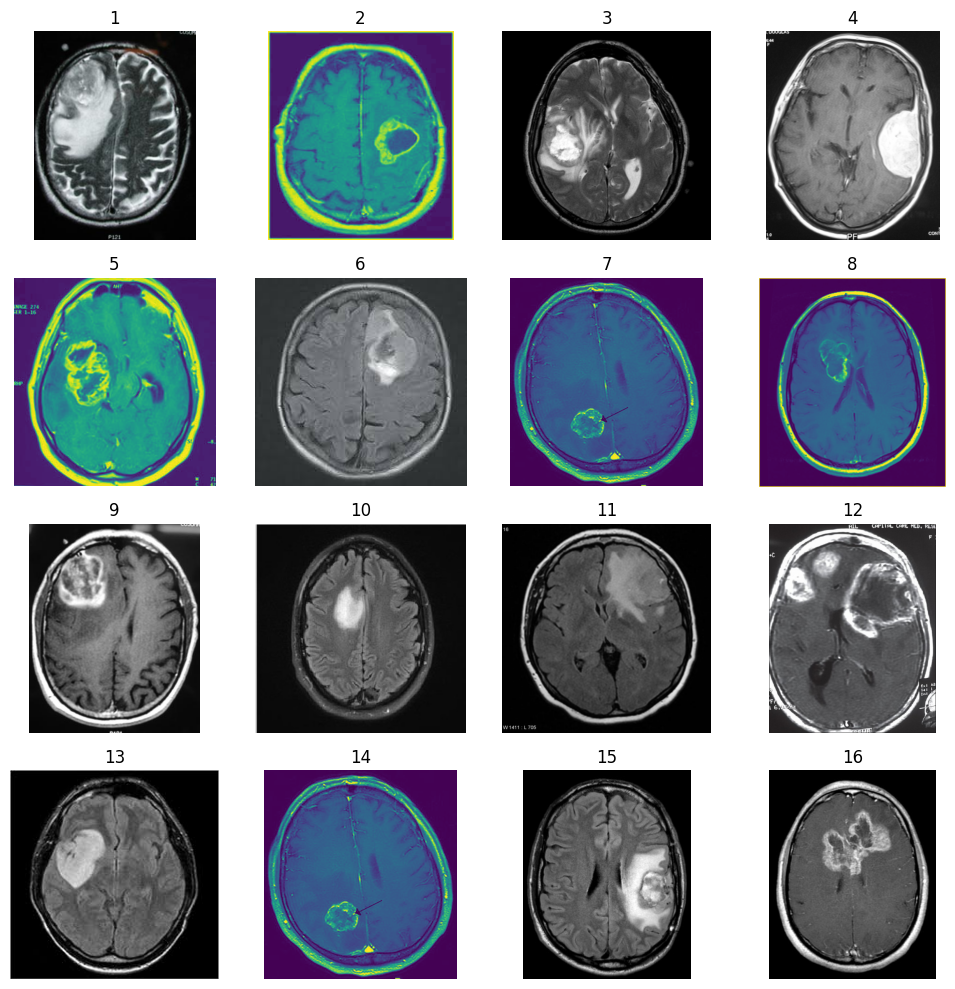

In [ ]:
from PIL import Image
num_images = min(16, len(image_files_yes))
rows, cols = 4, 4
fig, axes = plt.subplots(rows, cols, figsize= (10,10))
for i, ax in enumerate(axes.flat):
  image_path = os.path.join(dataset_path,"yes", image_files_yes[i])
  img = Image.open(image_path)
  ax.imshow(img)
  ax.set_title(f"{i+1}")
  ax.axis("off")
plt.tight_layout()
plt.show()

Found 92 images in 'no' category


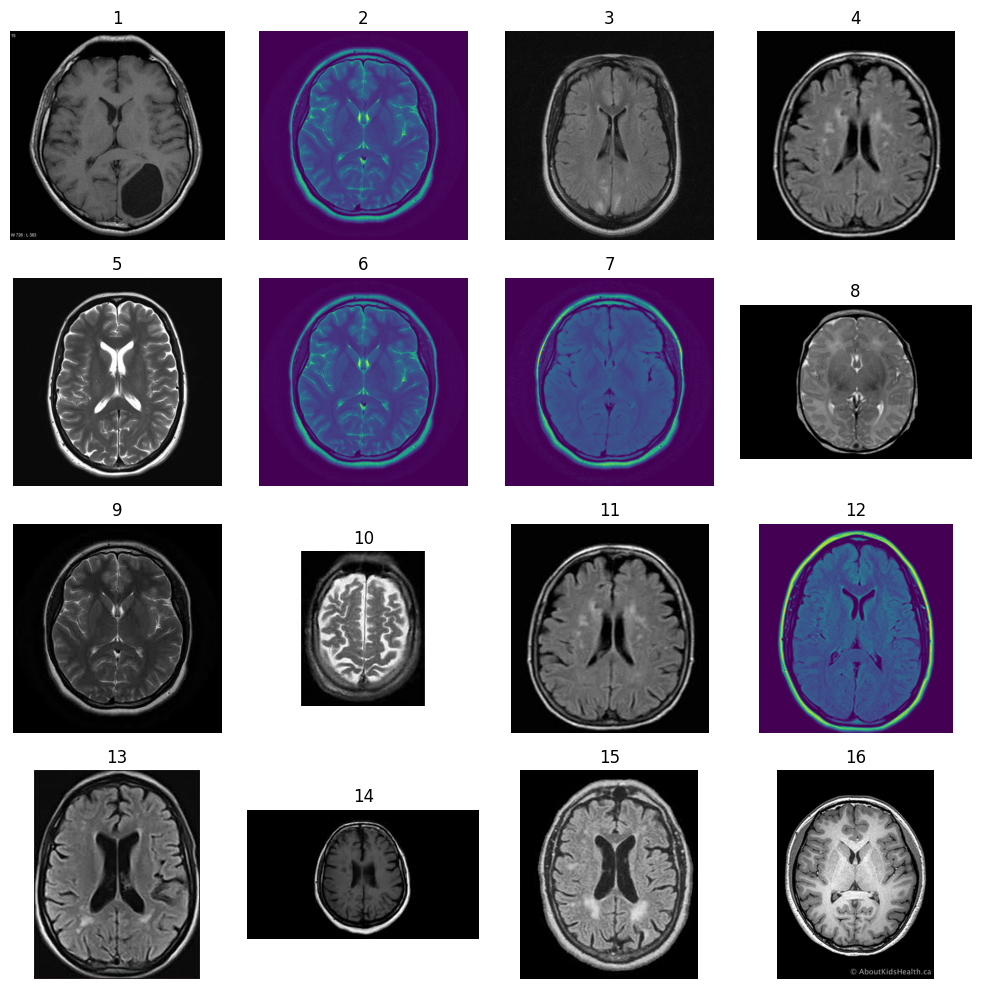

In [ ]:
image_files_no = [f for f in os.listdir(no_dataset_path) if f.endswith((".png", ".jpg", ".jpeg"))]
print(f"Found {len(image_files_no)} images in 'no' category")

from PIL import Image
num_images = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10,10))
for i, ax in enumerate(axes.flat):
  sample_image_path = os.path.join(no_dataset_path, image_files_no[i])
  img = Image.open(sample_image_path)
  ax.imshow(img)
  ax.set_title(f"{i+1}")
  ax.axis('off')
plt.tight_layout()
plt.show()

### Load the dataset by adding data augmentation followed by preparing iterable batches

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

import torchvision.transforms as transforms


train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Match input size of pretrained models
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],   # ImageNet stats
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

full_dataset = datasets.ImageFolder(root='content/dataset/brain_tumor_dataset', transform = train_transform)

train_size = int(len(full_dataset)*0.8)
test_size = len(full_dataset) - train_size

train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_dataset.dataset.transform = train_transform
test_dataset.dataset.transform = test_transform

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle = True, num_workers=2)
test_dataloader = DataLoader(test_dataset, shuffle = False, batch_size=32, num_workers=2)

len(train_dataloader), len(test_dataloader)


(7, 2)

In [ ]:
full_dataset

Dataset ImageFolder
    Number of datapoints: 253
    Root location: content/dataset/brain_tumor_dataset
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               RandomResizedCrop(size=(224, 224), scale=(0.9, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [ ]:
full_dataset.classes

['no', 'yes']

In [ ]:
full_dataset.class_to_idx

{'no': 0, 'yes': 1}

In [ ]:
sample_image_batch , sample_label_batch = next(iter(train_dataloader))
sample_image_batch.shape, sample_label_batch.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

In [ ]:
sample_image_batch[0].shape

torch.Size([3, 224, 224])

In [ ]:
sample_label_batch

tensor([1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1,
        1, 0, 0, 1, 1, 1, 0, 1])

### Randomly visualize the images from the batch selected along with the labels

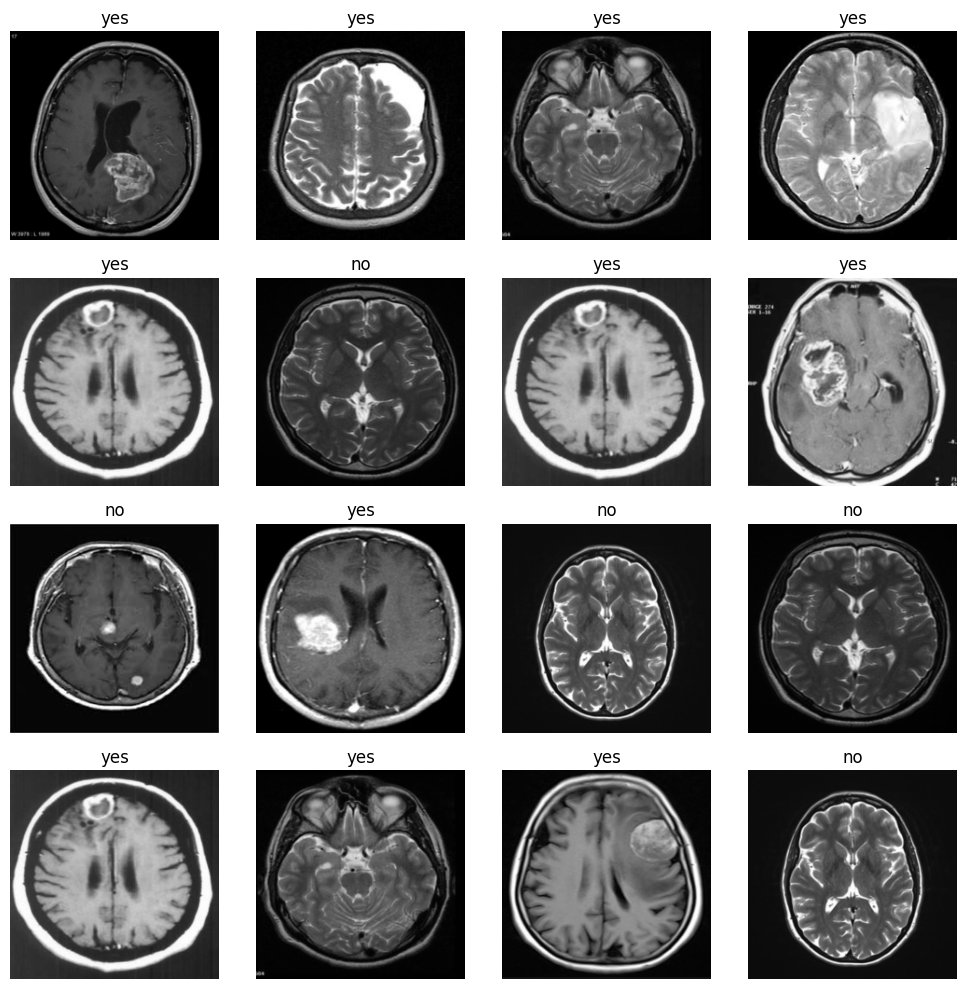

In [ ]:
import random
fig, axes = plt.subplots(rows, cols, figsize=(10,10))

for i , ax in enumerate(axes.flat):
  random_num = random.randint(1,16)
  sample_image = sample_image_batch[random_num]
  img = sample_image*0.5 +0.5
  img = np.clip(img.numpy().transpose((1, 2, 0)), 0, 1)
  ax.imshow(img)
  ax.set_title(f"{full_dataset.classes[sample_label_batch[random_num]]}")
  ax.axis("off")
plt.tight_layout()
plt.show()

## Create a function to evaluate the model

In [ ]:
def model_eval(dataloader, model, model_name,  loss_function):
    model.eval()
    test_loss = 0.0
    test_accuracy = 0.0  # ← ADD THIS LINE!

    with torch.no_grad():
      for data, target in dataloader:
        output = model(data)
        loss = loss_function(output, target)
        test_loss += loss.item()

        pred = torch.argmax(output, dim=1)
        test_accuracy += (pred == target).sum().item() / len(target)

    test_loss /= len(test_dataloader)
    test_accuracy /= len(test_dataloader)
    return {'Model': model_name,
            'Loss' : test_loss,
            'Accuracy': test_accuracy}

## Build the linear model

In [ ]:
class LinearModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear_layer = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=3*224*224, out_features=256),  # Increased hidden layer size
        nn.ReLU(),
        nn.Dropout(0.3),  # Dropout with 30% probability
        nn.Linear(in_features=256, out_features=64),
        nn.ReLU(),
        nn.Dropout(0.2),  # Optional second dropout
        nn.Linear(in_features=64, out_features=2)
        )
  def forward(self,x):
    return self.linear_layer(x)


In [ ]:
linear_model = LinearModel()

In [ ]:
linear_model.state_dict()

OrderedDict([('linear_layer.1.weight',
              tensor([[-0.0013, -0.0001,  0.0014,  ..., -0.0022, -0.0014, -0.0014],
                      [-0.0014, -0.0005,  0.0021,  ...,  0.0008, -0.0007, -0.0016],
                      [ 0.0003, -0.0020, -0.0013,  ..., -0.0010, -0.0011, -0.0002],
                      ...,
                      [ 0.0021,  0.0015, -0.0008,  ..., -0.0009,  0.0019,  0.0019],
                      [-0.0007,  0.0019,  0.0021,  ...,  0.0020, -0.0013, -0.0011],
                      [ 0.0009,  0.0016,  0.0022,  ...,  0.0004, -0.0024,  0.0011]])),
             ('linear_layer.1.bias',
              tensor([ 1.3554e-03, -2.4290e-03, -5.8689e-04,  1.0074e-03, -6.3785e-04,
                       7.9941e-04, -2.4372e-03,  2.0078e-03,  2.4502e-03, -1.9921e-03,
                      -2.8489e-04,  1.3773e-03,  5.7129e-04,  7.4401e-04, -1.4123e-03,
                      -1.9348e-03,  1.2898e-03, -5.1867e-05, -3.8036e-04, -2.1783e-03,
                       1.6950e-03, -2.3580

In [ ]:
linear_model

LinearModel(
  (linear_layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=150528, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=256, out_features=64, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.2, inplace=False)
    (7): Linear(in_features=64, out_features=2, bias=True)
  )
)

### Test the linear model with sample input

In [ ]:
sample_output = linear_model(sample_image_batch)
probs = torch.sigmoid(sample_output)
preds = (probs >0.5).long()
preds

tensor([[1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [0, 0],
        [0, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [0, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [0, 0],
        [0, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [0, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [0, 0],
        [1, 0]])

In [ ]:
import requests

request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
with open('helperfunctions.py', 'wb') as f:
  f.write(request.content)

from helperfunctions import accuracy_fn

### Create the loss function for Linear model

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = linear_model.parameters(), lr = 0.001)


### Building the training loop for linear model

In [ ]:
torch.manual_seed(42)
epochs = 30
for epoch in range(epochs):
  linear_model.train()
  train_loss = 0.0
  train_accuracy = 0.0
  for train_image, train_label in train_dataloader:
    optimizer.zero_grad()
    y_pred = linear_model(train_image)
    loss = loss_fn(y_pred, train_label)
    train_loss += loss.item()
    with torch.no_grad():
      preds = torch.argmax(y_pred, dim =1)
      train_accuracy += (preds == train_label).sum().item() / len(train_label)
    loss.backward()
    optimizer.step()
  train_loss /= len(train_dataloader)
  train_accuracy /= len(train_dataloader)

  linear_model.eval()
  test_loss = 0
  correct = 0

  with torch.no_grad():
      for data, target in test_dataloader:
        output = linear_model(data)
        loss = loss_fn(output, target)
        test_loss += loss.item()
        pred = output.argmax(dim=1)
        correct += pred.eq(target).sum().item()

  test_loss /= len(test_dataloader)
  test_accuracy = correct / len(test_dataset)


  print(f"Epoch: {epoch+1} | Train_Accuracy: {train_accuracy:.3f} | Train_Loss: {train_loss:.4f} | Test_Accuracy: {test_accuracy:.3f} | Test_Loss: {test_loss:.4f}")



Epoch: 1 | Train_Accuracy: 0.440 | Train_Loss: 0.7033 | Test_Accuracy: 0.412 | Test_Loss: 0.7159
Epoch: 2 | Train_Accuracy: 0.396 | Train_Loss: 0.7123 | Test_Accuracy: 0.412 | Test_Loss: 0.7159
Epoch: 3 | Train_Accuracy: 0.396 | Train_Loss: 0.7119 | Test_Accuracy: 0.412 | Test_Loss: 0.7159
Epoch: 4 | Train_Accuracy: 0.401 | Train_Loss: 0.7134 | Test_Accuracy: 0.412 | Test_Loss: 0.7159
Epoch: 5 | Train_Accuracy: 0.362 | Train_Loss: 0.7176 | Test_Accuracy: 0.412 | Test_Loss: 0.7159
Epoch: 6 | Train_Accuracy: 0.392 | Train_Loss: 0.7120 | Test_Accuracy: 0.412 | Test_Loss: 0.7159
Epoch: 7 | Train_Accuracy: 0.413 | Train_Loss: 0.7029 | Test_Accuracy: 0.412 | Test_Loss: 0.7159
Epoch: 8 | Train_Accuracy: 0.392 | Train_Loss: 0.7122 | Test_Accuracy: 0.412 | Test_Loss: 0.7159
Epoch: 9 | Train_Accuracy: 0.437 | Train_Loss: 0.6981 | Test_Accuracy: 0.412 | Test_Loss: 0.7159
Epoch: 10 | Train_Accuracy: 0.403 | Train_Loss: 0.7087 | Test_Accuracy: 0.412 | Test_Loss: 0.7159
Epoch: 11 | Train_Accuracy: 0

In [ ]:
linear_model_results = model_eval(dataloader=test_dataloader, model=linear_model,model_name='Linear_Model', loss_function = loss_fn )
linear_model_results

{'Model': 'Linear_Model',
 'Loss': 0.7158706784248352,
 'Accuracy': 0.39226973684210525}

## Build Non-Linear Model-Add Non Linearity to the model

In [ ]:
class NonLinear(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=3*224*224, out_features = 10),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(in_features=10, out_features=2)
    )
  def forward(self, x):
    return self.linear_stack(x)

In [ ]:
non_linear_model = NonLinear()
non_linear_model

NonLinear(
  (linear_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=150528, out_features=10, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=10, out_features=2, bias=True)
  )
)

In [ ]:
non_linear_model.state_dict()

OrderedDict([('linear_stack.1.weight',
              tensor([[ 1.9429e-04,  6.7590e-04, -1.3604e-03,  ...,  2.7127e-04,
                       -1.6193e-03,  8.4179e-04],
                      [ 1.1821e-04, -2.2135e-03, -2.1900e-03,  ...,  1.4658e-03,
                        2.0200e-03, -1.0554e-04],
                      [ 1.9655e-03,  3.7730e-04, -1.2969e-03,  ...,  1.2478e-05,
                        1.6670e-03,  1.5954e-03],
                      ...,
                      [-7.2011e-04,  2.5352e-03, -8.2978e-04,  ...,  1.7155e-03,
                        4.0761e-04,  1.2345e-03],
                      [-1.4481e-03, -1.5746e-03,  9.3486e-04,  ..., -4.7454e-04,
                       -1.7539e-03,  1.9728e-03],
                      [ 2.1989e-03,  1.2100e-04,  1.8986e-03,  ..., -2.3106e-03,
                        8.0478e-04,  1.1326e-03]])),
             ('linear_stack.1.bias',
              tensor([-0.0015,  0.0018,  0.0017, -0.0019,  0.0005,  0.0023, -0.0009,  0.0009,
              

### Test the non linear model with sample input

In [ ]:
sample_output = non_linear_model(sample_image_batch)

In [ ]:
sample_output

tensor([[ 0.0751,  0.0954],
        [ 0.1559, -0.0009],
        [ 0.1793,  0.0122],
        [ 0.0960,  0.0533],
        [ 0.0269,  0.1815],
        [ 0.0669,  0.0640],
        [ 0.0879,  0.0634],
        [ 0.1202,  0.1480],
        [ 0.2645,  0.3721],
        [ 0.1359,  0.1883],
        [ 0.0665,  0.0701],
        [ 0.0384,  0.0981],
        [ 0.1111,  0.0509],
        [ 0.0669,  0.0643],
        [ 0.0889,  0.1111],
        [ 0.0389,  0.1060],
        [ 0.0603,  0.1197],
        [ 0.0492,  0.1280],
        [ 0.1080,  0.1296],
        [ 0.1169,  0.2948],
        [ 0.0039,  0.2415],
        [ 0.0666,  0.0686],
        [ 0.0393,  0.1058],
        [ 0.0860,  0.0410],
        [ 0.0481,  0.0959],
        [ 0.0653,  0.0684],
        [ 0.0509,  0.0805],
        [ 0.0310,  0.1131],
        [ 0.0666,  0.0687],
        [ 0.0663,  0.0738],
        [ 0.0287,  0.1119],
        [-0.0572,  0.2436]], grad_fn=<AddmmBackward0>)

### Create loss function and optimizer for non linear model

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = non_linear_model.parameters(), lr = 0.001)

### Build the training loop for non linear model

In [ ]:
torch.manual_seed(42)
epochs = 30
for epoch in range(epochs):
  non_linear_model.train()
  train_loss = 0.0
  train_accuracy = 0.0
  for train_image, train_label in train_dataloader:
    optimizer.zero_grad()
    y_pred = non_linear_model(train_image)
    loss = loss_fn(y_pred, train_label)
    train_loss += loss.item()
    with torch.no_grad():
      preds = torch.argmax(y_pred, dim =1)
      train_accuracy += (preds == train_label).sum().item() / len(train_label)
    loss.backward()
    optimizer.step()
  train_loss /= len(train_dataloader)
  train_accuracy /= len(train_dataloader)

  non_linear_model.eval()
  test_loss = 0
  correct = 0

  with torch.no_grad():
      for data, target in test_dataloader:
        output = non_linear_model(data)
        loss = loss_fn(output, target)
        test_loss += loss.item()
        pred = output.argmax(dim=1)
        correct += pred.eq(target).sum().item()

  test_loss /= len(test_dataloader)
  test_accuracy = correct / len(test_dataset)


  print(f"Epoch: {epoch+1} | Train_Accuracy: {train_accuracy:.3f} | Train_Loss: {train_loss:.4f} | Test_Accuracy: {test_accuracy:.3f} | Test_Loss: {test_loss:.4f}")



Epoch: 1 | Train_Accuracy: 0.534 | Train_Loss: 0.6942 | Test_Accuracy: 0.686 | Test_Loss: 0.6806
Epoch: 2 | Train_Accuracy: 0.680 | Train_Loss: 0.6478 | Test_Accuracy: 0.588 | Test_Loss: 0.6495
Epoch: 3 | Train_Accuracy: 0.676 | Train_Loss: 0.5931 | Test_Accuracy: 0.588 | Test_Loss: 0.6460
Epoch: 4 | Train_Accuracy: 0.672 | Train_Loss: 0.5698 | Test_Accuracy: 0.588 | Test_Loss: 0.6648
Epoch: 5 | Train_Accuracy: 0.669 | Train_Loss: 0.5822 | Test_Accuracy: 0.667 | Test_Loss: 0.6537
Epoch: 6 | Train_Accuracy: 0.675 | Train_Loss: 0.6078 | Test_Accuracy: 0.627 | Test_Loss: 0.6652
Epoch: 7 | Train_Accuracy: 0.713 | Train_Loss: 0.5011 | Test_Accuracy: 0.667 | Test_Loss: 0.6635
Epoch: 8 | Train_Accuracy: 0.756 | Train_Loss: 0.5110 | Test_Accuracy: 0.706 | Test_Loss: 0.6630
Epoch: 9 | Train_Accuracy: 0.734 | Train_Loss: 0.4867 | Test_Accuracy: 0.588 | Test_Loss: 0.7722
Epoch: 10 | Train_Accuracy: 0.747 | Train_Loss: 0.5078 | Test_Accuracy: 0.647 | Test_Loss: 0.6554
Epoch: 11 | Train_Accuracy: 0

In [ ]:
non_linear_model_results = model_eval(dataloader=test_dataloader, model=non_linear_model, model_name='Non_Linear_Model', loss_function = loss_fn )
non_linear_model_results

{'Model': 'Non_Linear_Model',
 'Loss': 0.7867490649223328,
 'Accuracy': 0.712171052631579}

## Build CNN model

In [ ]:
class CNNModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
    self.relu1 = nn.ReLU()
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
    self.relu2 = nn.ReLU()
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
    self.relu3 = nn.ReLU()
    self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(128 * 28 * 28, 256)
    self.relu4 = nn.ReLU()
    self.dropout = nn.Dropout(0.5)
    self.fc2 = nn.Linear(256, 2)

  def forward(self, x):
    x = self.pool1(self.relu1(self.conv1(x)))
    x = self.pool2(self.relu2(self.conv2(x)))
    x = self.pool3(self.relu3(self.conv3(x)))
    x = self.flatten(x)
    x = self.relu4(self.fc1(x))
    x = self.fc2(x)
    return x



In [ ]:
cnn_model = CNNModel()

In [ ]:
cnn_model

CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=100352, out_features=256, bias=True)
  (relu4): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=2, bias=True)
)

In [ ]:
cnn_model.state_dict()

OrderedDict([('conv1.weight',
              tensor([[[[ 1.2245e-01, -1.1492e-01, -1.2590e-01],
                        [ 1.6795e-01,  6.8073e-02,  5.1130e-03],
                        [ 2.6045e-02, -1.5467e-01, -6.4256e-02]],
              
                       [[ 1.8526e-01, -4.7464e-02, -9.6541e-03],
                        [-1.5980e-01, -1.0766e-01, -3.9298e-03],
                        [-1.1954e-01, -2.3866e-02,  7.8319e-02]],
              
                       [[-1.8825e-01,  5.7160e-02, -1.2725e-01],
                        [-9.3925e-02,  7.3883e-02,  1.5302e-01],
                        [-5.2598e-02, -7.9014e-02, -1.7402e-01]]],
              
              
                      [[[-9.9238e-02, -1.6852e-01, -4.4046e-02],
                        [ 3.9270e-02, -1.8030e-01,  1.6803e-01],
                        [ 1.2074e-01, -1.8840e-01, -9.1921e-02]],
              
                       [[ 6.2769e-02, -3.9541e-02, -2.0973e-02],
                        [-8.6894e-02,  1.5458

### Testing the CNN model with sample input

In [ ]:
sample_output = cnn_model(sample_image_batch)
sample_output

tensor([[ 0.0124, -0.0336],
        [ 0.0206, -0.0413],
        [ 0.0105, -0.0447],
        [ 0.0072, -0.0394],
        [ 0.0175, -0.0485],
        [ 0.0138, -0.0333],
        [ 0.0208, -0.0401],
        [ 0.0195, -0.0410],
        [ 0.0131, -0.0613],
        [ 0.0123, -0.0484],
        [ 0.0127, -0.0517],
        [ 0.0131, -0.0391],
        [ 0.0191, -0.0442],
        [ 0.0188, -0.0403],
        [ 0.0020, -0.0444],
        [ 0.0154, -0.0428],
        [ 0.0167, -0.0406],
        [ 0.0110, -0.0441],
        [ 0.0151, -0.0397],
        [ 0.0194, -0.0356],
        [ 0.0077, -0.0366],
        [ 0.0090, -0.0389],
        [ 0.0154, -0.0446],
        [ 0.0095, -0.0381],
        [ 0.0174, -0.0339],
        [ 0.0172, -0.0418],
        [ 0.0120, -0.0456],
        [ 0.0086, -0.0422],
        [ 0.0105, -0.0443],
        [ 0.0146, -0.0368],
        [ 0.0163, -0.0405],
        [ 0.0168, -0.0409]], grad_fn=<AddmmBackward0>)

### Create loss function and optimizer for the CNN model

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=1e-4, weight_decay=1e-5)

### Add the scheduler step

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


### Build the training loop for CNN model

In [ ]:
torch.manual_seed(42)
epochs = 50
best_loss = float('inf')      # 🟢 Define only ONCE before loop
patience = 5
trigger_times = 0
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []
for epoch in range(epochs):
  cnn_model.train()
  train_loss = 0.0
  train_accuracy = 0.0

  for train_image, train_label in train_dataloader:
    optimizer.zero_grad()
    y_pred = cnn_model(train_image)
    loss = loss_fn(y_pred, train_label)
    train_loss += loss.item()

    with torch.no_grad():
      preds = torch.argmax(y_pred, dim=1)
      train_accuracy += (preds == train_label).sum().item() / len(train_label)

    loss.backward()
    optimizer.step()

  train_loss /= len(train_dataloader)
  train_accuracy /= len(train_dataloader)

  cnn_model.eval()
  test_loss = 0.0
  test_accuracy = 0.0  # ← ADD THIS LINE!

  with torch.no_grad():
    for data, target in test_dataloader:
      output = cnn_model(data)
      loss = loss_fn(output, target)
      test_loss += loss.item()

      pred = torch.argmax(output, dim=1)
      test_accuracy += (pred == target).sum().item() / len(target)

  test_loss /= len(test_dataloader)
  scheduler.step(test_loss)
  test_accuracy /= len(test_dataloader)

  print(f"Epoch: {epoch+1} | Train_Accuracy: {train_accuracy:.3f} | Train_Loss: {train_loss:.4f} | Test_Accuracy: {test_accuracy:.3f} | Test_Loss: {test_loss:.4f}")


  # Inside your loop:
  train_losses.append(train_loss)
  test_losses.append(test_loss)
  train_accuracies.append(train_accuracy)
  test_accuracies.append(test_accuracy)

    # 🔁 Early Stopping
  if test_loss < best_loss:
      best_loss = test_loss
      trigger_times = 0
      torch.save(cnn_model.state_dict(), "best_model.pt")
  else:
      trigger_times += 1
      print(f"EarlyStopping counter: {trigger_times} out of {patience}")
      if trigger_times >= patience:
          print("Early stopping triggered! ✅")
          break


Epoch: 1 | Train_Accuracy: 0.631 | Train_Loss: 0.6298 | Test_Accuracy: 0.502 | Test_Loss: 0.6809
Epoch: 2 | Train_Accuracy: 0.677 | Train_Loss: 0.5664 | Test_Accuracy: 0.754 | Test_Loss: 0.7032
EarlyStopping counter: 1 out of 5
Epoch: 3 | Train_Accuracy: 0.798 | Train_Loss: 0.4537 | Test_Accuracy: 0.712 | Test_Loss: 0.6660
Epoch: 4 | Train_Accuracy: 0.843 | Train_Loss: 0.3984 | Test_Accuracy: 0.712 | Test_Loss: 0.7189
EarlyStopping counter: 1 out of 5
Epoch: 5 | Train_Accuracy: 0.828 | Train_Loss: 0.4037 | Test_Accuracy: 0.728 | Test_Loss: 0.7221
EarlyStopping counter: 2 out of 5
Epoch: 6 | Train_Accuracy: 0.870 | Train_Loss: 0.3290 | Test_Accuracy: 0.712 | Test_Loss: 0.7580
EarlyStopping counter: 3 out of 5
Epoch: 7 | Train_Accuracy: 0.842 | Train_Loss: 0.3330 | Test_Accuracy: 0.697 | Test_Loss: 0.8159
EarlyStopping counter: 4 out of 5
Epoch: 8 | Train_Accuracy: 0.879 | Train_Loss: 0.2845 | Test_Accuracy: 0.712 | Test_Loss: 0.8124
EarlyStopping counter: 5 out of 5
Early stopping trigg

### Visualize the train and test lossess for the CNN model

In [ ]:
train_losses, test_losses

([0.6298282401902335,
  0.5664208105632237,
  0.45365743551935467,
  0.39844702397074017,
  0.40370373853615354,
  0.32902262466294424,
  0.3330351880618504,
  0.2844909919159753],
 [0.6809341311454773,
  0.7032045722007751,
  0.6659690737724304,
  0.7188915610313416,
  0.722139984369278,
  0.7580253779888153,
  0.8159261345863342,
  0.8124172687530518])

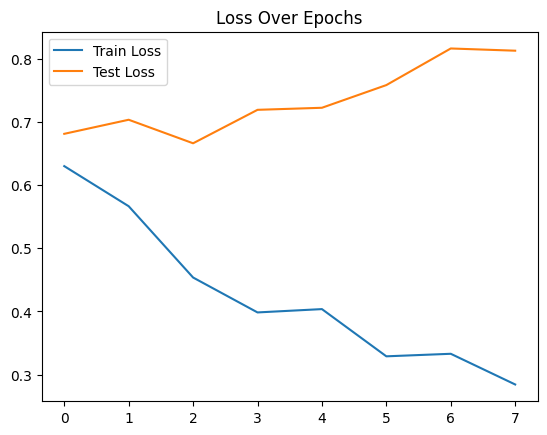

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.show()


In [ ]:
cnn_best_model = CNNModel()
cnn_best_model.load_state_dict(torch.load("best_model.pt"))

<All keys matched successfully>

### Printing CNN Model results

In [ ]:
cnn_model_results = model_eval(dataloader = test_dataloader, model = cnn_best_model, model_name = 'CNN_Model', loss_function=loss_fn)
cnn_model_results

{'Model': 'CNN_Model',
 'Loss': 0.6659690737724304,
 'Accuracy': 0.712171052631579}

## Build the Resnet-18 pretrained model

In [ ]:
from torchvision import models

resnet_18_model = models.resnet18(pretrained=True)

for param in resnet_18_model.parameters():
    param.requires_grad = False

resnet_18_model.fc = nn.Sequential(
        nn.Linear(resnet_18_model.fc.in_features, 256),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(256, 2)
    )

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 136MB/s]


### Create loss function and optimizer

In [ ]:
optimizer = torch.optim.Adam(resnet_18_model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, verbose=True)
loss_fn = nn.CrossEntropyLoss()

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


### Build the training loop for resnet-18 model

In [ ]:
torch.manual_seed(42)
epochs = 50
best_loss = float('inf')      # 🟢 Define only ONCE before loop
patience = 5
trigger_times = 0
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []
for epoch in range(epochs):
  resnet_18_model.train()
  train_loss = 0.0
  train_accuracy = 0.0

  for train_image, train_label in train_dataloader:
    optimizer.zero_grad()
    y_pred = resnet_18_model(train_image)
    loss = loss_fn(y_pred, train_label)
    train_loss += loss.item()

    with torch.no_grad():
      preds = torch.argmax(y_pred, dim=1)
      train_accuracy += (preds == train_label).sum().item() / len(train_label)

    loss.backward()
    optimizer.step()

  train_loss /= len(train_dataloader)
  train_accuracy /= len(train_dataloader)

  resnet_18_model.eval()
  test_loss = 0.0
  test_accuracy = 0.0  # ← ADD THIS LINE!

  with torch.no_grad():
    for data, target in test_dataloader:
      output = resnet_18_model(data)
      loss = loss_fn(output, target)
      test_loss += loss.item()

      pred = torch.argmax(output, dim=1)
      test_accuracy += (pred == target).sum().item() / len(target)

  test_loss /= len(test_dataloader)
  scheduler.step(test_loss)
  test_accuracy /= len(test_dataloader)

  print(f"Epoch: {epoch+1} | Train_Accuracy: {train_accuracy:.3f} | Train_Loss: {train_loss:.4f} | Test_Accuracy: {test_accuracy:.3f} | Test_Loss: {test_loss:.4f}")


  # Inside your loop:
  train_losses.append(train_loss)
  test_losses.append(test_loss)
  train_accuracies.append(train_accuracy)
  test_accuracies.append(test_accuracy)

    # 🔁 Early Stopping
  if test_loss < best_loss:
      best_loss = test_loss
      trigger_times = 0
      torch.save(resnet_18_model.state_dict(), "best_model.pt")
  else:
      trigger_times += 1
      print(f"EarlyStopping counter: {trigger_times} out of {patience}")
      if trigger_times >= patience:
          print("Early stopping triggered! ✅")
          break


Epoch: 1 | Train_Accuracy: 0.630 | Train_Loss: 0.6453 | Test_Accuracy: 0.392 | Test_Loss: 1.1095
Epoch: 2 | Train_Accuracy: 0.605 | Train_Loss: 0.6232 | Test_Accuracy: 0.623 | Test_Loss: 0.6230
Epoch: 3 | Train_Accuracy: 0.771 | Train_Loss: 0.4842 | Test_Accuracy: 0.796 | Test_Loss: 0.4821
Epoch: 4 | Train_Accuracy: 0.825 | Train_Loss: 0.4292 | Test_Accuracy: 0.723 | Test_Loss: 0.5993
EarlyStopping counter: 1 out of 5
Epoch: 5 | Train_Accuracy: 0.796 | Train_Loss: 0.4111 | Test_Accuracy: 0.833 | Test_Loss: 0.4046
Epoch: 6 | Train_Accuracy: 0.798 | Train_Loss: 0.4252 | Test_Accuracy: 0.796 | Test_Loss: 0.4377
EarlyStopping counter: 1 out of 5
Epoch: 7 | Train_Accuracy: 0.863 | Train_Loss: 0.2971 | Test_Accuracy: 0.780 | Test_Loss: 0.3893
Epoch: 8 | Train_Accuracy: 0.883 | Train_Loss: 0.3093 | Test_Accuracy: 0.780 | Test_Loss: 0.3981
EarlyStopping counter: 1 out of 5
Epoch: 9 | Train_Accuracy: 0.879 | Train_Loss: 0.2478 | Test_Accuracy: 0.827 | Test_Loss: 0.3631
Epoch: 10 | Train_Accurac

### Visualize the train and test lossess for Resnet-18 model

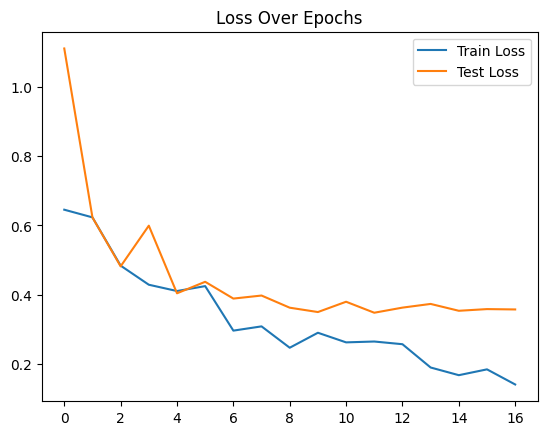

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.show()


### Calculate the confusion matrix anf classification report for the predictions made by Resnet-18 model

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
def evaluate_model(model, dataloader, class_names = ['No Tumor', 'Tumor']):
    y_true = []
    y_pred = []
    model.eval()

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    return cm, report


In [ ]:
import torch
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Load the model
model = models.resnet18(weights=None)
model.fc = torch.nn.Sequential(
    torch.nn.Linear(model.fc.in_features, 256),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.4),
    torch.nn.Linear(256, 2)
)

model.load_state_dict(torch.load("best_model.pt", map_location=torch.device('cpu')))
model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
y_true, y_pred = [], []
class_names = ["No Tumor", "Tumor"]
with torch.no_grad():
    for images, labels in test_dataloader:
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(preds.numpy())

cm = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)


#### Heatmap for the confusion matrix of Resnet-18 predictions confusion matrix

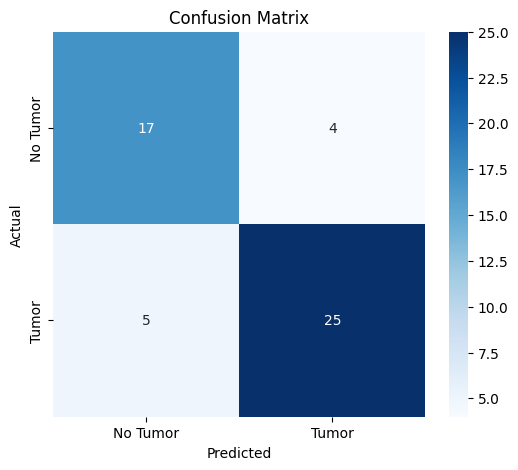

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


#### Classification report of the Resnet-18 predictions

In [ ]:
print("Classification Report:")
for label in class_names:
    precision = report[label]['precision']
    recall = report[label]['recall']
    f1 = report[label]['f1-score']
    support = report[label]['support']
    print(f"{label}: Precision={precision:.2f}, Recall={recall:.2f}, F1-score={f1:.2f}, Support={support}")

print(f"\nOverall Accuracy: {report['accuracy']:.2f}")


Classification Report:
No Tumor: Precision=0.77, Recall=0.81, F1-score=0.79, Support=21.0
Tumor: Precision=0.86, Recall=0.83, F1-score=0.85, Support=30.0

Overall Accuracy: 0.82


In [ ]:
!pip install grad-cam --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 24.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 84.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 63.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 51.2 MB/s e

### Visualizing the tumor area using Grad-CAM

In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import preprocess_image

In [ ]:
from torchvision import models
import torch.nn as nn
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

resnet_18_model = models.resnet18(weights=None)  # weights=None to suppress deprecation warning
resnet_18_model.fc = nn.Sequential(
    nn.Linear(resnet_18_model.fc.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 2)
)

resnet_18_model.load_state_dict(torch.load("best_model.pt", map_location=device))
resnet_18_model.to(device)
resnet_18_model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
resnet_18_model_results = model_eval(dataloader=test_dataloader,
                                     model = resnet_18_model,
                                     model_name = 'Resnet_18',
                                     loss_function=loss_fn)
resnet_18_model_results

{'Model': 'Resnet_18',
 'Loss': 0.3580317795276642,
 'Accuracy': 0.8536184210526316}

In [ ]:
image_path = os.path.join(dataset_path, "yes", image_files_yes[2])

# Same transforms you used for training (resize, normalize)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]) # typical ImageNet normalization
])

# Load and transform
img = Image.open(image_path).convert('RGB')
input_tensor = transform(img).unsqueeze(0)  # Add batch dimension


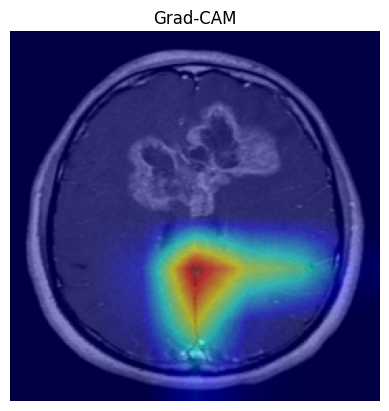

In [ ]:
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam import GradCAM

# Pick the last convolutional layer of your model
target_layers = [resnet_18_model.layer4[-1]]  # For resnet18

# Create GradCAM object
cam = GradCAM(model=resnet_18_model, target_layers=target_layers)

# Define target class (optional). If None, uses model prediction.
targets = [ClassifierOutputTarget(1)]  # 1 = e.g. Malignant

# Generate CAM
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]

# Convert image to RGB for overlay
rgb_img = np.array(img.resize((224, 224))) / 255.0

# Overlay heatmap
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

# Show
plt.imshow(visualization)
plt.axis('off')
plt.title("Grad-CAM")
plt.show()


### Comparing the normal image with GRAD-CAM image along with Raw Grad-CAM image

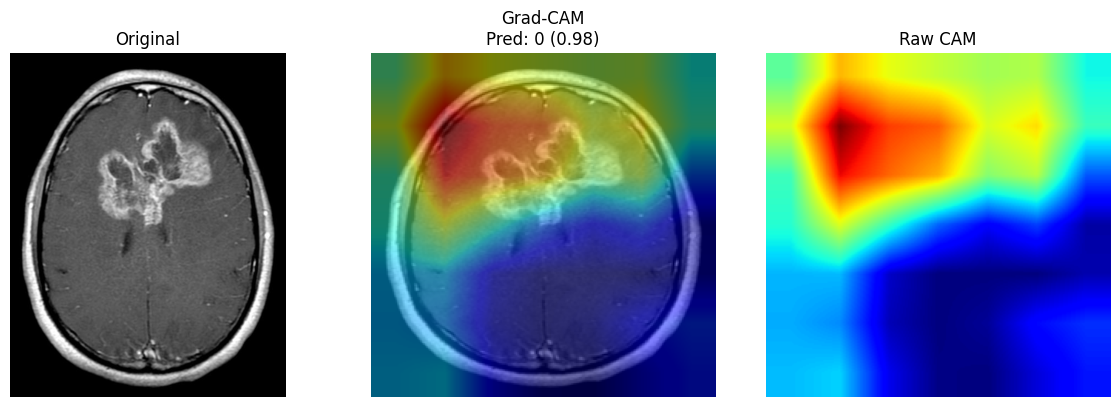

In [ ]:
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from PIL import Image
import numpy as np

# Step 1: Load image and preprocess
img_path = os.path.join(dataset_path, "yes", image_files_yes[2])
image = Image.open(img_path).convert('RGB')

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

input_tensor = transform(image).unsqueeze(0).to(device)

# Step 2: Get prediction
with torch.no_grad():
    outputs = resnet_18_model(input_tensor)
    probs = torch.nn.functional.softmax(outputs, dim=1)
    conf, pred = torch.max(probs, 1)
target_layers = [resnet_18_model.layer4[-1]]
# Step 3: Get Grad-CAM
gradcam = GradCAM(model=resnet_18_model, target_layers=target_layers)  # or correct final conv layer

grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(pred.item())])[0]


# Step 4: Overlay CAM on image
def overlay_heatmap(img_pil, cam, alpha=0.5):
    img = np.array(img_pil.resize((224, 224)))
    heatmap = plt.cm.jet(cam)[..., :3] * 255
    overlay = (alpha * heatmap + (1 - alpha) * img).astype(np.uint8)
    return Image.fromarray(overlay)

overlayed_img = overlay_heatmap(image, grayscale_cam)



# Step 5: Plot all
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(overlayed_img)
plt.title(f"Grad-CAM\nPred: {pred.item()} ({conf.item():.2f})")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(grayscale_cam, cmap='jet')
plt.title("Raw CAM")
plt.axis('off')

plt.tight_layout()
plt.show()


### Visualizing the Truth Vs Predicted labels for the Restnet-18 predictions

In [ ]:
class_names = {0: "Negative", 1: "Positive"}  # Adjust to your task


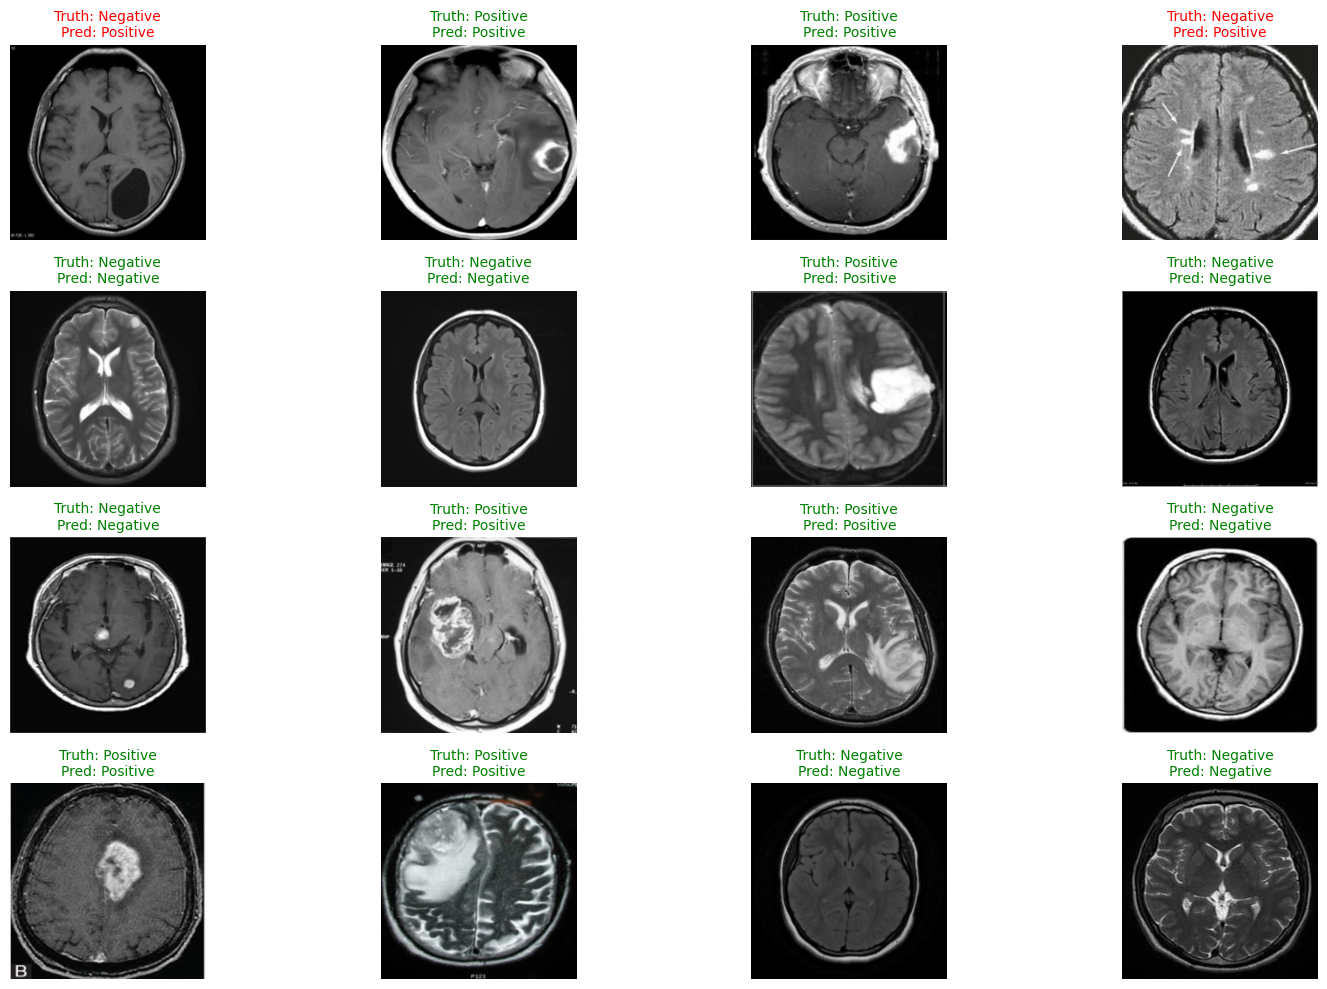

In [ ]:
import torch
import matplotlib.pyplot as plt
import random

# Set model to evaluation mode
resnet_18_model.eval()

# Load one full batch from the test set
images, labels = next(iter(test_dataloader))
images = images.to(device)
labels = labels.to(device)

# Predict
with torch.no_grad():
    outputs = resnet_18_model(images)
    _, preds = torch.max(outputs, 1)

# Sample 16 random indices
indices = random.sample(range(len(images)), 16)

# Plot 16 images
plt.figure(figsize=(16, 10))
for i, idx in enumerate(indices):
    img = images[idx].cpu()
    label = labels[idx].item()
    pred = preds[idx].item()
    img = img*0.5 +0.5
    img = np.clip(img.numpy().transpose((1, 2, 0)), 0, 1)
    color = 'green' if label == pred else 'red'
    plt.subplot(4, 4, i + 1)
    plt.imshow(img.squeeze(), cmap='gray')  # Use `.squeeze()` if grayscale
    plt.title(f"Truth: {class_names[label]}\nPred: {class_names[pred]}", fontsize=10, color = color)
    plt.axis('off')

plt.tight_layout()
plt.show()


## Building Resnet-50 Model

In [ ]:
from torchvision import models
resnet_50_model = models.resnet50(pretrained=True)

for param in resnet_50_model.parameters():
  param.requires_grad = False

resnet_50_model.fc = nn.Sequential(
        nn.Linear(resnet_50_model.fc.in_features, 256),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(256, 2)
    )

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
resnet_50_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
resnet_50_model.state_dict()

OrderedDict([('conv1.weight',
              tensor([[[[ 1.3335e-02,  1.4664e-02, -1.5351e-02,  ..., -4.0896e-02,
                         -4.3034e-02, -7.0755e-02],
                        [ 4.1205e-03,  5.8477e-03,  1.4948e-02,  ...,  2.2060e-03,
                         -2.0912e-02, -3.8517e-02],
                        [ 2.2331e-02,  2.3595e-02,  1.6120e-02,  ...,  1.0281e-01,
                          6.2641e-02,  5.1977e-02],
                        ...,
                        [-9.0349e-04,  2.7767e-02, -1.0105e-02,  ..., -1.2722e-01,
                         -7.6604e-02,  7.8453e-03],
                        [ 3.5894e-03,  4.8006e-02,  6.2051e-02,  ...,  2.4267e-02,
                         -3.3662e-02, -1.5709e-02],
                        [-8.0029e-02, -3.2238e-02, -1.7808e-02,  ...,  3.5359e-02,
                          2.2439e-02,  1.7077e-03]],
              
                       [[-1.8452e-02,  1.1415e-02,  2.3850e-02,  ...,  5.3736e-02,
                          4.4022

### Creating the loss function and optimizer for Resnet-50 model

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet_50_model.parameters(), lr = 0.001)

### Build training loop for resnet-50 model

In [ ]:
torch.manual_seed(42)
epochs = 50
best_loss = float('inf')      # 🟢 Define only ONCE before loop
patience = 5
trigger_times = 0
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []
for epoch in range(epochs):
  resnet_50_model.train()
  train_loss = 0.0
  train_accuracy = 0.0

  for train_image, train_label in train_dataloader:
    optimizer.zero_grad()
    y_pred = resnet_50_model(train_image)
    loss = loss_fn(y_pred, train_label)
    train_loss += loss.item()

    with torch.no_grad():
      preds = torch.argmax(y_pred, dim=1)
      train_accuracy += (preds == train_label).sum().item() / len(train_label)

    loss.backward()
    optimizer.step()

  train_loss /= len(train_dataloader)
  train_accuracy /= len(train_dataloader)

  resnet_50_model.eval()
  test_loss = 0.0
  test_accuracy = 0.0  # ← ADD THIS LINE!

  with torch.no_grad():
    for data, target in test_dataloader:
      output = resnet_50_model(data)
      loss = loss_fn(output, target)
      test_loss += loss.item()

      pred = torch.argmax(output, dim=1)
      test_accuracy += (pred == target).sum().item() / len(target)

  test_loss /= len(test_dataloader)
  scheduler.step(test_loss)
  test_accuracy /= len(test_dataloader)

  print(f"Epoch: {epoch+1} | Train_Accuracy: {train_accuracy:.3f} | Train_Loss: {train_loss:.4f} | Test_Accuracy: {test_accuracy:.3f} | Test_Loss: {test_loss:.4f}")


  # Inside your loop:
  train_losses.append(train_loss)
  test_losses.append(test_loss)
  train_accuracies.append(train_accuracy)
  test_accuracies.append(test_accuracy)

    # 🔁 Early Stopping
  if test_loss < best_loss:
      best_loss = test_loss
      trigger_times = 0
      torch.save(resnet_50_model.state_dict(), "resnet_50_best_model.pt")
  else:
      trigger_times += 1
      print(f"EarlyStopping counter: {trigger_times} out of {patience}")
      if trigger_times >= patience:
          print("Early stopping triggered! ✅")
          break


Epoch: 1 | Train_Accuracy: 0.662 | Train_Loss: 0.6408 | Test_Accuracy: 0.392 | Test_Loss: 1.5525
Epoch: 2 | Train_Accuracy: 0.569 | Train_Loss: 0.8250 | Test_Accuracy: 0.639 | Test_Loss: 0.5891
Epoch: 3 | Train_Accuracy: 0.776 | Train_Loss: 0.4830 | Test_Accuracy: 0.770 | Test_Loss: 0.5049
Epoch: 4 | Train_Accuracy: 0.862 | Train_Loss: 0.3701 | Test_Accuracy: 0.812 | Test_Loss: 0.4463
Epoch: 5 | Train_Accuracy: 0.823 | Train_Loss: 0.3865 | Test_Accuracy: 0.796 | Test_Loss: 0.4587
EarlyStopping counter: 1 out of 5
Epoch: 6 | Train_Accuracy: 0.792 | Train_Loss: 0.4124 | Test_Accuracy: 0.843 | Test_Loss: 0.3791
Epoch: 7 | Train_Accuracy: 0.882 | Train_Loss: 0.3122 | Test_Accuracy: 0.896 | Test_Loss: 0.3659
Epoch: 8 | Train_Accuracy: 0.887 | Train_Loss: 0.2751 | Test_Accuracy: 0.880 | Test_Loss: 0.3573
Epoch: 9 | Train_Accuracy: 0.914 | Train_Loss: 0.2706 | Test_Accuracy: 0.896 | Test_Loss: 0.3387
Epoch: 10 | Train_Accuracy: 0.902 | Train_Loss: 0.2399 | Test_Accuracy: 0.864 | Test_Loss: 0.

### Loading the best model to calculate the confusion matrix and classification report

In [ ]:
import torch
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Load the model
resnet_50_model = models.resnet50(weights=None)
resnet_50_model.fc = nn.Sequential(
        nn.Linear(resnet_50_model.fc.in_features, 256),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(256, 2)
    )

resnet_50_model.load_state_dict(torch.load("resnet_50_best_model.pt", map_location=torch.device('cpu')))
resnet_50_model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Printing resnet 50 model results

In [ ]:
resnet_50_results = model_eval(dataloader=test_dataloader,
                               model = model,model_name = 'Resnet-50', loss_function = loss_fn)
resnet_50_results

{'Model': 'Resnet-50',
 'Loss': 0.34857673943042755,
 'Accuracy': 0.8273026315789473}

### Compute confusion matrix and classification report

In [ ]:
y_true, y_pred = [], []
class_names = ["No Tumor", "Tumor"]
with torch.no_grad():
    for images, labels in test_dataloader:
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(preds.numpy())

cm = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)


### Heatmap of the Confusion matrix of the resnet-50 predictions

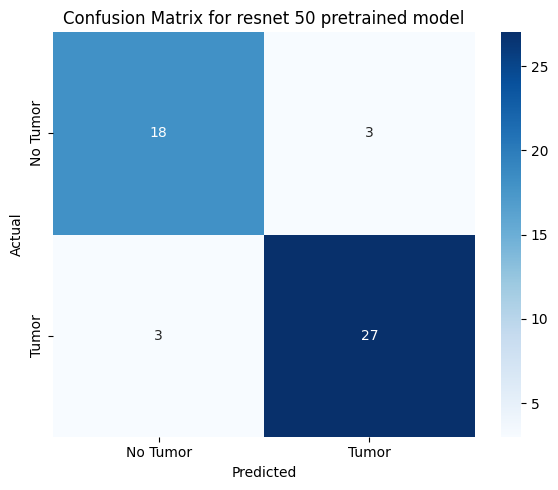

In [ ]:

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for resnet 50 pretrained model")
plt.tight_layout()
plt.show()


### Calculating precision, recall and F-1 score for the Resnet-50 model

In [ ]:

print("Classification Report:")
for label in class_names:
    precision = report[label]['precision']
    recall = report[label]['recall']
    f1 = report[label]['f1-score']
    support = report[label]['support']
    print(f"{label}: Precision={precision:.2f}, Recall={recall:.2f}, F1-score={f1:.2f}, Support={support}")

print(f"\nOverall Accuracy: {report['accuracy']:.2f}")

Classification Report:
No Tumor: Precision=0.86, Recall=0.86, F1-score=0.86, Support=21.0
Tumor: Precision=0.90, Recall=0.90, F1-score=0.90, Support=30.0

Overall Accuracy: 0.88


## Building Efficient_b0 pretrained model

In [ ]:
from torchvision import models

efficient_b0_model = models.efficientnet_b0(pretrained = True)
for param in efficient_b0_model.parameters():
  param.requires_grad = False

efficient_b0_model.classifier = nn.Sequential(
        nn.Linear(efficient_b0_model.classifier[1].in_features, 1280),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(1280, 2)
    )

efficient_b0_model

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
efficient_b0_model.state_dict()

OrderedDict([('features.0.0.weight',
              tensor([[[[ 1.2156e-01,  6.5634e-01,  4.5671e-01],
                        [-1.1092e-01, -6.1004e-01, -3.3345e-01],
                        [ 2.7964e-02, -1.0312e-01, -1.0324e-01]],
              
                       [[ 6.3553e-02,  1.6552e+00,  1.7436e+00],
                        [-1.3646e-01, -1.5367e+00, -1.5937e+00],
                        [ 5.0196e-02, -1.1360e-01, -1.2600e-01]],
              
                       [[ 8.7276e-02,  3.6126e-01,  2.6946e-01],
                        [-1.1966e-01, -2.8122e-01, -2.1883e-01],
                        [ 3.6658e-02, -7.0751e-02, -8.1917e-02]]],
              
              
                      [[[ 1.6449e-01, -2.0041e-01,  8.3092e-02],
                        [ 8.9009e-01, -1.2110e+00,  2.7610e-01],
                        [ 1.0740e+00, -1.2603e+00,  2.0645e-01]],
              
                       [[ 3.2816e-01, -4.3449e-01,  1.8769e-01],
                        [ 1.6213e+00, 

### Create loss function and optimizer for the Efficient B0 model

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(efficient_b0_model.parameters(), lr=1e-4)

### Building training loop for the efficient b0 model

In [179]:
torch.manual_seed(42)
epochs = 50
best_loss = float('inf')      # 🟢 Define only ONCE before loop
patience = 5
trigger_times = 0
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []
for epoch in range(epochs):
  efficient_b0_model.train()
  train_loss = 0.0
  train_accuracy = 0.0

  for train_image, train_label in train_dataloader:
    optimizer.zero_grad()
    y_pred = efficient_b0_model(train_image)
    loss = loss_fn(y_pred, train_label)
    train_loss += loss.item()

    with torch.no_grad():
      preds = torch.argmax(y_pred, dim=1)
      train_accuracy += (preds == train_label).sum().item() / len(train_label)

    loss.backward()
    optimizer.step()

  train_loss /= len(train_dataloader)
  train_accuracy /= len(train_dataloader)

  efficient_b0_model.eval()
  test_loss = 0.0
  test_accuracy = 0.0  # ← ADD THIS LINE!

  with torch.no_grad():
    for data, target in test_dataloader:
      output = efficient_b0_model(data)
      loss = loss_fn(output, target)
      test_loss += loss.item()

      pred = torch.argmax(output, dim=1)
      test_accuracy += (pred == target).sum().item() / len(target)

  test_loss /= len(test_dataloader)
  scheduler.step(test_loss)
  test_accuracy /= len(test_dataloader)

  print(f"Epoch: {epoch+1} | Train_Accuracy: {train_accuracy:.3f} | Train_Loss: {train_loss:.4f} | Test_Accuracy: {test_accuracy:.3f} | Test_Loss: {test_loss:.4f}")


  # Inside your loop:
  train_losses.append(train_loss)
  test_losses.append(test_loss)
  train_accuracies.append(train_accuracy)
  test_accuracies.append(test_accuracy)

    # 🔁 Early Stopping
  if test_loss < best_loss:
      best_loss = test_loss
      trigger_times = 0
      torch.save(efficient_b0_model.state_dict(), "efficient_b0_best_model.pt")
  else:
      trigger_times += 1
      print(f"EarlyStopping counter: {trigger_times} out of {patience}")
      if trigger_times >= patience:
          print("Early stopping triggered! ✅")
          break


Epoch: 1 | Train_Accuracy: 0.667 | Train_Loss: 0.6423 | Test_Accuracy: 0.770 | Test_Loss: 0.6036
Epoch: 2 | Train_Accuracy: 0.731 | Train_Loss: 0.5440 | Test_Accuracy: 0.780 | Test_Loss: 0.5468
Epoch: 3 | Train_Accuracy: 0.757 | Train_Loss: 0.5064 | Test_Accuracy: 0.796 | Test_Loss: 0.5263
Epoch: 4 | Train_Accuracy: 0.843 | Train_Loss: 0.4667 | Test_Accuracy: 0.827 | Test_Loss: 0.5063
Epoch: 5 | Train_Accuracy: 0.902 | Train_Loss: 0.4208 | Test_Accuracy: 0.812 | Test_Loss: 0.4858
Epoch: 6 | Train_Accuracy: 0.893 | Train_Loss: 0.3791 | Test_Accuracy: 0.896 | Test_Loss: 0.4547
Epoch: 7 | Train_Accuracy: 0.911 | Train_Loss: 0.3459 | Test_Accuracy: 0.896 | Test_Loss: 0.4301
Epoch: 8 | Train_Accuracy: 0.911 | Train_Loss: 0.3186 | Test_Accuracy: 0.896 | Test_Loss: 0.4135
Epoch: 9 | Train_Accuracy: 0.942 | Train_Loss: 0.2715 | Test_Accuracy: 0.896 | Test_Loss: 0.3761
Epoch: 10 | Train_Accuracy: 0.929 | Train_Loss: 0.2785 | Test_Accuracy: 0.896 | Test_Loss: 0.3410
Epoch: 11 | Train_Accuracy: 0

### Visualize the train and test losses for the efficient b0 model

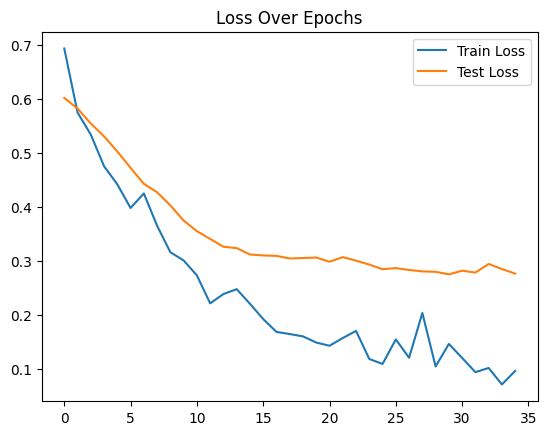

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.show()


### Building another training loop for efficient b0 after adding more data augmentation

In [ ]:
torch.manual_seed(42)
epochs = 50
best_loss = float('inf')      # 🟢 Define only ONCE before loop
patience = 5
trigger_times = 0
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []
for epoch in range(epochs):
  efficient_b0_model.train()
  train_loss = 0.0
  train_accuracy = 0.0

  for train_image, train_label in train_dataloader:
    optimizer.zero_grad()
    y_pred = efficient_b0_model(train_image)
    loss = loss_fn(y_pred, train_label)
    train_loss += loss.item()

    with torch.no_grad():
      preds = torch.argmax(y_pred, dim=1)
      train_accuracy += (preds == train_label).sum().item() / len(train_label)

    loss.backward()
    optimizer.step()

  train_loss /= len(train_dataloader)
  train_accuracy /= len(train_dataloader)

  efficient_b0_model.eval()
  test_loss = 0.0
  test_accuracy = 0.0  # ← ADD THIS LINE!

  with torch.no_grad():
    for data, target in test_dataloader:
      output = efficient_b0_model(data)
      loss = loss_fn(output, target)
      test_loss += loss.item()

      pred = torch.argmax(output, dim=1)
      test_accuracy += (pred == target).sum().item() / len(target)

  test_loss /= len(test_dataloader)
  scheduler.step(test_loss)
  test_accuracy /= len(test_dataloader)

  print(f"Epoch: {epoch+1} | Train_Accuracy: {train_accuracy:.3f} | Train_Loss: {train_loss:.4f} | Test_Accuracy: {test_accuracy:.3f} | Test_Loss: {test_loss:.4f}")


  # Inside your loop:
  train_losses.append(train_loss)
  test_losses.append(test_loss)
  train_accuracies.append(train_accuracy)
  test_accuracies.append(test_accuracy)

    # 🔁 Early Stopping
  if test_loss < best_loss:
      best_loss = test_loss
      trigger_times = 0
      torch.save(efficient_b0_model.state_dict(), "efficient_b0_best_model.pt")
  else:
      trigger_times += 1
      print(f"EarlyStopping counter: {trigger_times} out of {patience}")
      if trigger_times >= patience:
          print("Early stopping triggered! ✅")
          break


Epoch: 1 | Train_Accuracy: 0.590 | Train_Loss: 0.6549 | Test_Accuracy: 0.827 | Test_Loss: 0.6108
Epoch: 2 | Train_Accuracy: 0.709 | Train_Loss: 0.5654 | Test_Accuracy: 0.796 | Test_Loss: 0.5542
Epoch: 3 | Train_Accuracy: 0.721 | Train_Loss: 0.5146 | Test_Accuracy: 0.827 | Test_Loss: 0.5338
Epoch: 4 | Train_Accuracy: 0.807 | Train_Loss: 0.4823 | Test_Accuracy: 0.869 | Test_Loss: 0.5147
Epoch: 5 | Train_Accuracy: 0.875 | Train_Loss: 0.4309 | Test_Accuracy: 0.869 | Test_Loss: 0.4939
Epoch: 6 | Train_Accuracy: 0.888 | Train_Loss: 0.3896 | Test_Accuracy: 0.896 | Test_Loss: 0.4639
Epoch: 7 | Train_Accuracy: 0.902 | Train_Loss: 0.3478 | Test_Accuracy: 0.896 | Test_Loss: 0.4397
Epoch: 8 | Train_Accuracy: 0.911 | Train_Loss: 0.3296 | Test_Accuracy: 0.896 | Test_Loss: 0.4243
Epoch: 9 | Train_Accuracy: 0.929 | Train_Loss: 0.2831 | Test_Accuracy: 0.896 | Test_Loss: 0.3851
Epoch: 10 | Train_Accuracy: 0.920 | Train_Loss: 0.2823 | Test_Accuracy: 0.896 | Test_Loss: 0.3480
Epoch: 11 | Train_Accuracy: 0

### Loading the best model of efficient b0 model

In [180]:
import torch
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Load the model
model = models.efficientnet_b0(pretrained = True)

model.classifier = nn.Sequential(
        nn.Linear(model.classifier[1].in_features, 1280),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(1280, 2)
    )


model.load_state_dict(torch.load("efficient_b0_best_model.pt", map_location=torch.device('cpu')))
model.eval()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [181]:
efficient_b0_model_results = model_eval(dataloader=test_dataloader,
                                        model = model,model_name = 'EfficientNet',
                                        loss_function=loss_fn)
efficient_b0_model_results

{'Model': 'EfficientNet',
 'Loss': 0.20336561650037766,
 'Accuracy': 0.8955592105263157}

### calculating the confusion matrix and classification report for the efficient b0 model predictions

In [182]:
y_true, y_pred = [], []
class_names = ["No Tumor", "Tumor"]
with torch.no_grad():
    for images, labels in test_dataloader:
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(preds.numpy())

cm = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)


### Heatmap of the Efficient_b0 model's confusion matrix

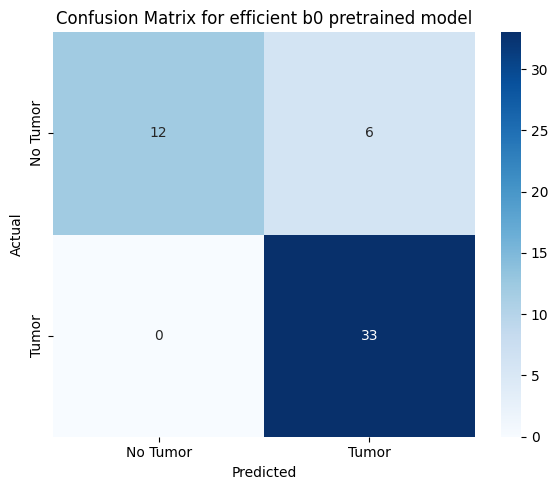

In [185]:

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for efficient b0 pretrained model")
plt.tight_layout()
plt.show()


### Classification report showing Precision, Recall, and F1-Score for the efficient-b0 model's predictions

In [186]:

print("Classification Report:")
for label in class_names:
    precision = report[label]['precision']
    recall = report[label]['recall']
    f1 = report[label]['f1-score']
    support = report[label]['support']
    print(f"{label}: Precision={precision:.2f}, Recall={recall:.2f}, F1-score={f1:.2f}, Support={support}")

print(f"\nOverall Accuracy: {report['accuracy']:.2f}")

Classification Report:
No Tumor: Precision=1.00, Recall=0.67, F1-score=0.80, Support=18.0
Tumor: Precision=0.85, Recall=1.00, F1-score=0.92, Support=33.0

Overall Accuracy: 0.88


## Building Efficient B3 Model

In [ ]:
from torchvision import models
import torch.nn as nn

# Load EfficientNet-B3
efficient_b3 = models.efficientnet_b3(pretrained=True)

# Freeze all layers
for param in efficient_b3.parameters():
    param.requires_grad = False

# Replace the classifier head
efficient_b3.classifier = nn.Sequential(
    nn.Linear(efficient_b3.classifier[1].in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, 2)  # 2 classes: Tumor / No Tumor
)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 88.5MB/s]


In [ ]:
efficient_b3

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

### Create loss function and optimizer for efficient b3

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(efficient_b0_model.parameters(), lr=1e-4)

### Building training loop for efficient b3 model

In [ ]:
torch.manual_seed(42)
epochs = 50
best_loss = float('inf')      # 🟢 Define only ONCE before loop
patience = 5
trigger_times = 0
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []
for epoch in range(epochs):
  efficient_b3.train()
  train_loss = 0.0
  train_accuracy = 0.0

  for train_image, train_label in train_dataloader:
    optimizer.zero_grad()
    y_pred = efficient_b3(train_image)
    loss = loss_fn(y_pred, train_label)
    train_loss += loss.item()

    with torch.no_grad():
      preds = torch.argmax(y_pred, dim=1)
      train_accuracy += (preds == train_label).sum().item() / len(train_label)

    loss.backward()
    optimizer.step()

  train_loss /= len(train_dataloader)
  train_accuracy /= len(train_dataloader)

  efficient_b3.eval()
  test_loss = 0.0
  test_accuracy = 0.0  # ← ADD THIS LINE!

  with torch.no_grad():
    for data, target in test_dataloader:
      output = efficient_b3(data)
      loss = loss_fn(output, target)
      test_loss += loss.item()

      pred = torch.argmax(output, dim=1)
      test_accuracy += (pred == target).sum().item() / len(target)

  test_loss /= len(test_dataloader)
  scheduler.step(test_loss)
  test_accuracy /= len(test_dataloader)

  print(f"Epoch: {epoch+1} | Train_Accuracy: {train_accuracy:.3f} | Train_Loss: {train_loss:.4f} | Test_Accuracy: {test_accuracy:.3f} | Test_Loss: {test_loss:.4f}")


  # Inside your loop:
  train_losses.append(train_loss)
  test_losses.append(test_loss)
  train_accuracies.append(train_accuracy)
  test_accuracies.append(test_accuracy)

    # 🔁 Early Stopping
  if test_loss < best_loss:
      best_loss = test_loss
      trigger_times = 0
      torch.save(efficient_b3.state_dict(), "efficient_b3_best_model.pt")
  else:
      trigger_times += 1

      print(f"EarlyStopping counter: {trigger_times} out of {patience}")
      if trigger_times >= patience:
          print("Early stopping triggered! ✅")
          break


Epoch: 1 | Train_Accuracy: 0.538 | Train_Loss: 0.6866 | Test_Accuracy: 0.650 | Test_Loss: 0.6796
Epoch: 2 | Train_Accuracy: 0.606 | Train_Loss: 0.6833 | Test_Accuracy: 0.571 | Test_Loss: 0.6850
EarlyStopping counter: 1 out of 5
Epoch: 3 | Train_Accuracy: 0.494 | Train_Loss: 0.6949 | Test_Accuracy: 0.560 | Test_Loss: 0.6864
EarlyStopping counter: 2 out of 5
Epoch: 4 | Train_Accuracy: 0.513 | Train_Loss: 0.6967 | Test_Accuracy: 0.544 | Test_Loss: 0.6893
EarlyStopping counter: 3 out of 5
Epoch: 5 | Train_Accuracy: 0.498 | Train_Loss: 0.6953 | Test_Accuracy: 0.560 | Test_Loss: 0.6895
EarlyStopping counter: 4 out of 5
Epoch: 6 | Train_Accuracy: 0.485 | Train_Loss: 0.6980 | Test_Accuracy: 0.602 | Test_Loss: 0.6903
EarlyStopping counter: 5 out of 5
Early stopping triggered! ✅


In [190]:
efficient_b3_results = model_eval(dataloader= test_dataloader, model = efficient_b3, model_name='Efficient_B3', loss_function = loss_fn)
efficient_b3_results

{'Model': 'Efficient_B3',
 'Loss': 0.6902835965156555,
 'Accuracy': 0.6019736842105263}

## Compare the results of all the models built


In [191]:
import pandas as pd

results = [linear_model_results, non_linear_model_results, cnn_model_results, resnet_18_model_results, resnet_50_results, efficient_b0_model_results, efficient_b3_results]

df = pd.DataFrame(results)
df



Model      Loss  Accuracy
0      Linear_Model  0.715871  0.392270
1  Non_Linear_Model  0.786749  0.712171
2         CNN_Model  0.665969  0.712171
3         Resnet_18  0.358032  0.853618
4         Resnet-50  0.348577  0.827303
5      EfficientNet  0.203366  0.895559
6      Efficient_B3  0.690284  0.601974

### Visualization of accuracies of various models

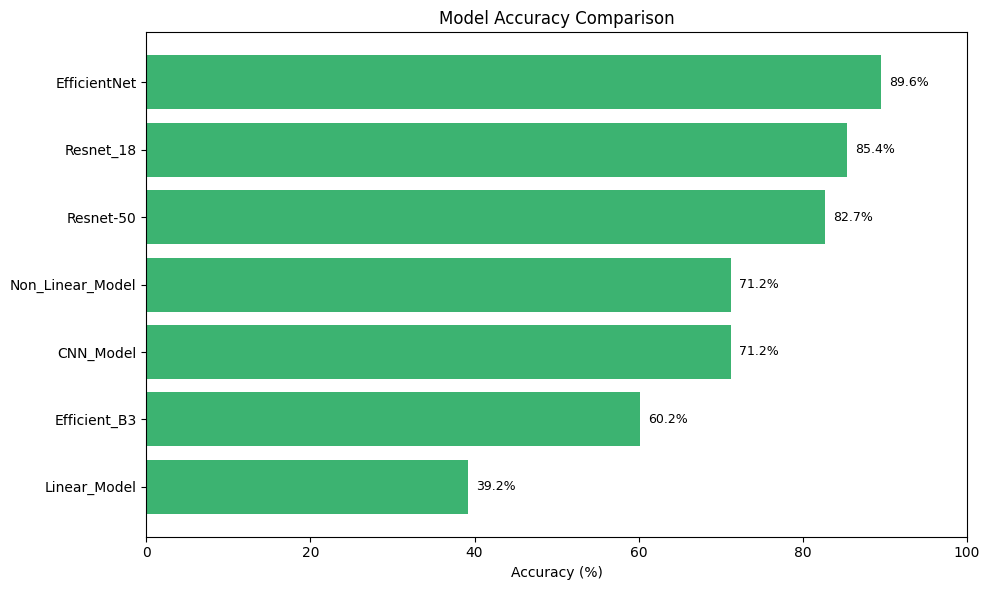

In [192]:
df['Accuracy (%)'] = df['Accuracy'] * 100
df = df.sort_values(by='Accuracy (%)', ascending=False)
# Plot
plt.figure(figsize=(10, 6))
bars = plt.barh(df['Model'], df['Accuracy (%)'], color='mediumseagreen')

plt.xlim(0, 100)
plt.xlabel("Accuracy (%)")
plt.title("Model Accuracy Comparison")

# Add percentage labels next to bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 1, bar.get_y() + bar.get_height()/2, f"{width:.1f}%", va='center', fontsize=9)

plt.tight_layout()
plt.gca().invert_yaxis()  # Optional: highest accuracy on top
plt.show()